In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# **Import data**

In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv('exportforuconn.csv')

# Remove unrelated columns
columns_to_remove = ['Load_Avg_1min_NIX', 'process_count', 'Disk_Max', 'TXMbps', 'RXMbps', 'CPU_Max', 'Mem_Max']
df = df.drop(columns=columns_to_remove)

# Print the DataFrame
print(df)

# Print the columns
print(df.columns)

                                _time                    host  Mem_Avg  \
0       2023-09-17T09:45:00.000+00:00  qabw3kzc42.example.com      NaN   
1       2023-09-17T09:45:00.000+00:00  qpdm5272g2.example.com      NaN   
2       2023-09-17T09:50:00.000+00:00  9p27d1k01y.example.com      NaN   
3       2023-09-17T09:50:00.000+00:00  tms0un2pm7.example.com      NaN   
4       2023-09-17T09:55:00.000+00:00  zlc9q3dcp7.example.com      NaN   
...                               ...                     ...      ...   
780781  2023-10-17T19:30:00.000+00:00  sk4o7o35ex.example.com      NaN   
780782  2023-10-17T19:30:00.000+00:00  jg630tu182.example.com     24.8   
780783  2023-10-17T19:30:00.000+00:00  0c7orz2oz7.example.com      NaN   
780784  2023-10-17T19:30:00.000+00:00  srvjo4438z.example.com      NaN   
780785  2023-10-17T19:30:00.000+00:00  5l0fs49py9.example.com      NaN   

        CPU_95th_Perc  Disk_Avg  
0                 NaN     17.00  
1                 NaN      2.00  
2        

# **Metadata**

In [24]:
# Group the data by the '_time' column
grouped_data = df.groupby('_time')

# Get the number of pings
num_pings = grouped_data.ngroups

# Print the number of pings
print("Number of 5 minute pings:", num_pings)


# Group the data by the 'host' column
grouped_servers = df.groupby('host')

# Get the number of hosts
num_hosts = grouped_servers.ngroups

# Print the number of pings
print("Number of servers:", num_hosts)

Number of 5 minute pings: 8758
Number of servers: 286


# **Find anomalies**

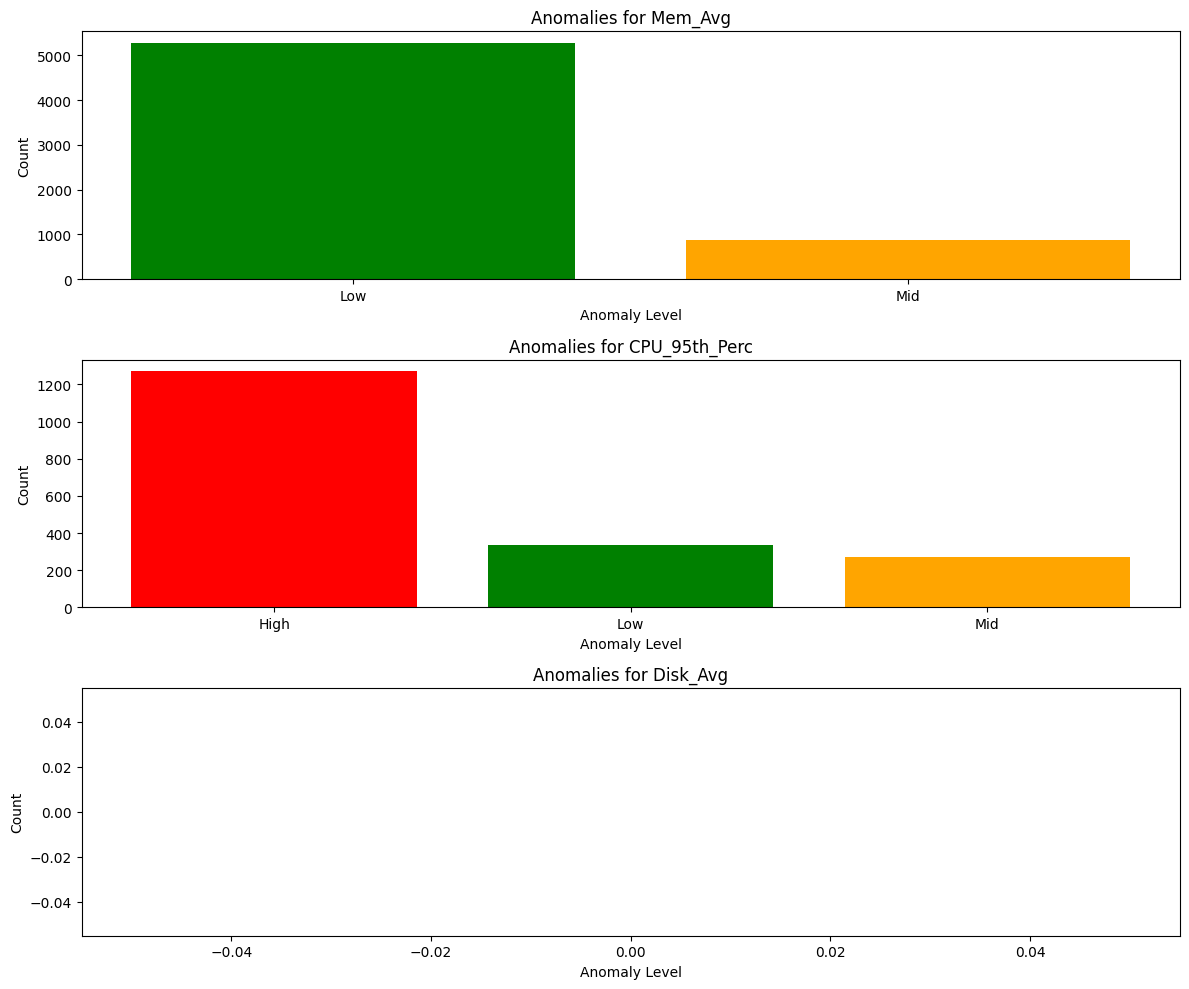

In [23]:
# Define thresholds for anomaly detection
mem_thresholds = {'low': 80, 'mid': 90, 'high': 99}
cpu_thresholds = {'low': 80, 'mid': 90, 'high': 99}
disk_thresholds = {'low': 80, 'mid': 90, 'high': 99}

# Find anomalies for each metric and label them
df.loc[df['Mem_Avg'] > mem_thresholds['high'], 'Mem_Level'] = 'High'
df.loc[(df['Mem_Avg'] > mem_thresholds['mid']) & (df['Mem_Avg'] <= mem_thresholds['high']), 'Mem_Level'] = 'Mid'
df.loc[(df['Mem_Avg'] > mem_thresholds['low']) & (df['Mem_Avg'] <= mem_thresholds['mid']), 'Mem_Level'] = 'Low'

df.loc[df['CPU_95th_Perc'] > cpu_thresholds['high'], 'CPU_Level'] = 'High'
df.loc[(df['CPU_95th_Perc'] > cpu_thresholds['mid']) & (df['CPU_95th_Perc'] <= cpu_thresholds['high']), 'CPU_Level'] = 'Mid'
df.loc[(df['CPU_95th_Perc'] > cpu_thresholds['low']) & (df['CPU_95th_Perc'] <= cpu_thresholds['mid']), 'CPU_Level'] = 'Low'

df.loc[df['Disk_Avg'] > disk_thresholds['high'], 'Disk_Level'] = 'High'
df.loc[(df['Disk_Avg'] > disk_thresholds['mid']) & (df['Disk_Avg'] <= disk_thresholds['high']), 'Disk_Level'] = 'Mid'
df.loc[(df['Disk_Avg'] > disk_thresholds['low']) & (df['Disk_Avg'] <= disk_thresholds['mid']), 'Disk_Level'] = 'Low'

# Concatenate all anomalies
all_anomalies = df[['host', '_time', 'Mem_Avg', 'CPU_95th_Perc', 'Disk_Avg', 'Mem_Level', 'CPU_Level', 'Disk_Level']]

# Count the number of anomalies for each metric
mem_anomaly_counts = all_anomalies['Mem_Level'].value_counts().to_dict()
cpu_anomaly_counts = all_anomalies['CPU_Level'].value_counts().to_dict()
disk_anomaly_counts = all_anomalies['Disk_Level'].value_counts().to_dict()

# Create lists for anomaly counts and metric names
anomaly_counts = [mem_anomaly_counts, cpu_anomaly_counts, disk_anomaly_counts]
metrics = ['Mem_Avg', 'CPU_95th_Perc', 'Disk_Avg']

# Define colors for each anomaly level
colors = {'Low': 'green', 'Mid': 'orange', 'High': 'red'}

# Create subplots for each metric
fig, axs = plt.subplots(3, 1, figsize=(12, 10))

# Plot bar chart for each metric
for i, metric in enumerate(metrics):
    counts = anomaly_counts[i]
    axs[i].bar(counts.keys(), counts.values(), color=[colors.get(level, 'blue') for level in counts.keys()])
    axs[i].set_title(f'Anomalies for {metric}')
    axs[i].set_xlabel('Anomaly Level')
    axs[i].set_ylabel('Count')

plt.tight_layout()
plt.show()


# **Generate chart to see anomaly data**

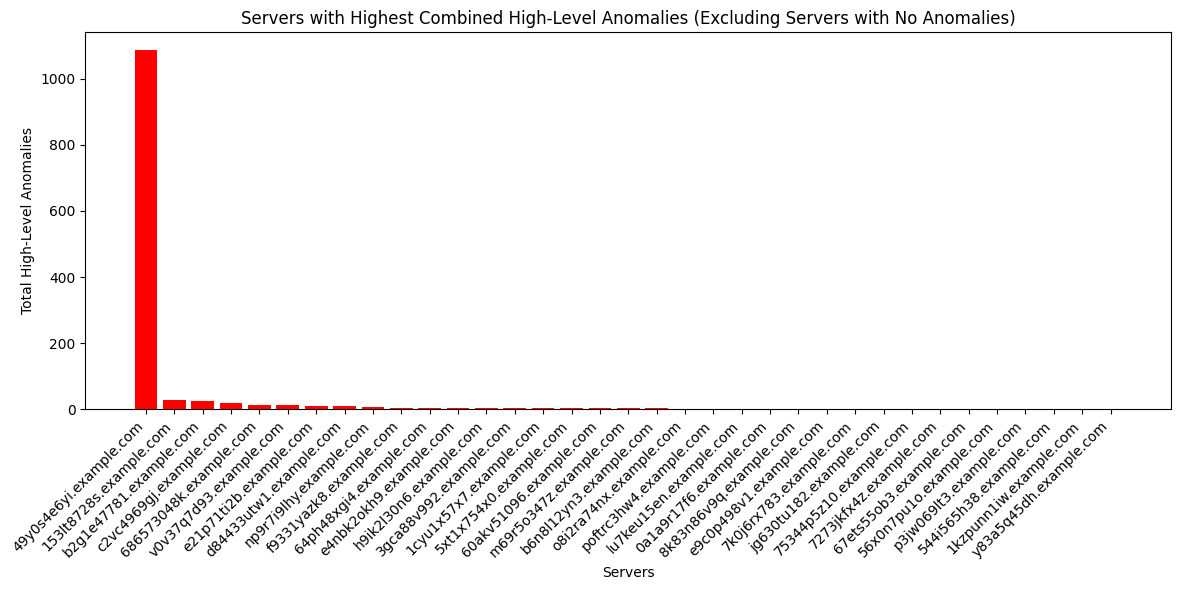

In [22]:
# Calculate total high anomalies
all_anomalies.loc[:, 'Total_High_Anomalies'] = (all_anomalies['Mem_Level'] == 'High') + \
                                               (all_anomalies['CPU_Level'] == 'High') + \
                                               (all_anomalies['Disk_Level'] == 'High')

# Group by server and sum the total high-level anomalies
server_anomaly_counts = all_anomalies.groupby('host')['Total_High_Anomalies'].sum().reset_index()

# Exclude servers with no anomalies
server_anomaly_counts = server_anomaly_counts[server_anomaly_counts['Total_High_Anomalies'] > 0]

# Sort the dataframe by the total high-level anomalies
server_anomaly_counts = server_anomaly_counts.sort_values(by='Total_High_Anomalies', ascending=False)

# Generate bar chart
plt.figure(figsize=(12, 6))
plt.bar(server_anomaly_counts['host'], server_anomaly_counts['Total_High_Anomalies'], color='red')
plt.xlabel('Servers')
plt.ylabel('Total High-Level Anomalies')
plt.title('Servers with Highest Combined High-Level Anomalies (Excluding Servers with No Anomalies)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# **As we can see, we found a server with anomaly level metrics,**
# Let's display its stats

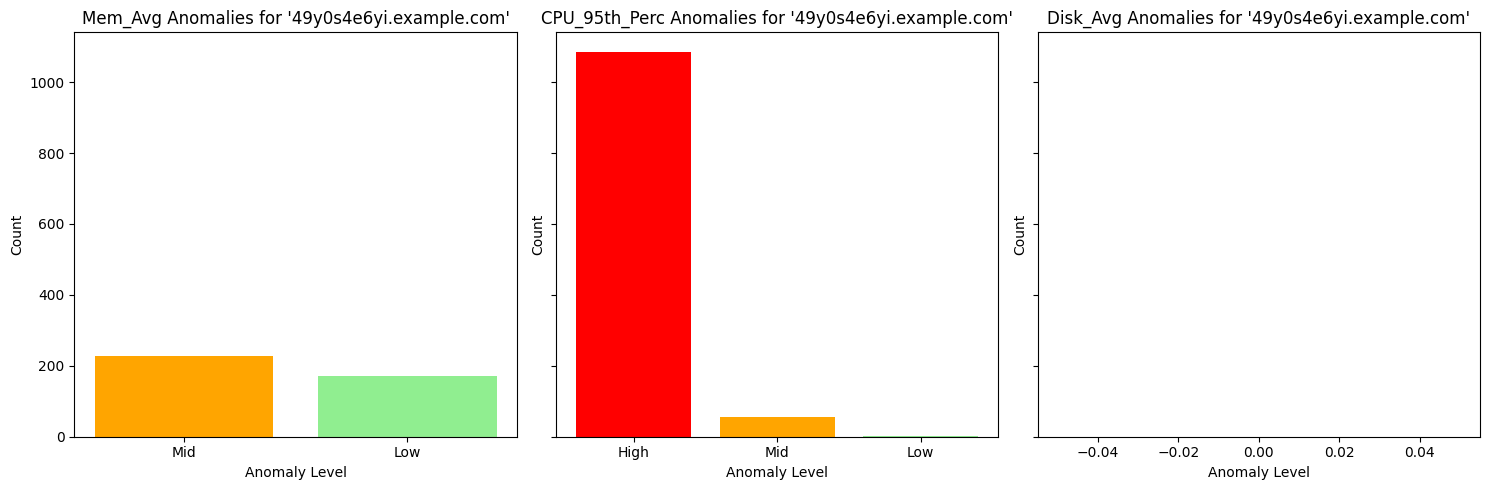

In [19]:
# Find the server with the highest number of anomalies
server_with_highest_anomalies = server_anomaly_counts.iloc[0]['host']

# Filter the DataFrame to get anomaly metric counts for the server with the highest number of anomalies
metrics_for_highest_anomalies = all_anomalies[all_anomalies['host'] == server_with_highest_anomalies][['Mem_Level', 'CPU_Level', 'Disk_Level']]

# Count the occurrences of each anomaly level for each metric
metric_counts = {
    'Mem_Avg': metrics_for_highest_anomalies['Mem_Level'].value_counts().to_dict(),
    'CPU_95th_Perc': metrics_for_highest_anomalies['CPU_Level'].value_counts().to_dict(),
    'Disk_Avg': metrics_for_highest_anomalies['Disk_Level'].value_counts().to_dict()
}

# Data preparation
metric_names = ['Mem_Avg', 'CPU_95th_Perc', 'Disk_Avg']
metric_labels = ['Memory', 'CPU', 'Disk']
metric_colors = {'low': 'lightgreen', 'mid': 'orange', 'high': 'red'}

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

for i, metric in enumerate(metric_names):
    ax = axes[i]
    counts = metric_counts[metric]
    ax.bar(counts.keys(), counts.values(), color=[metric_colors[level.lower()] for level in counts.keys()])
    ax.set_title(f"{metric} Anomalies for '{server_with_highest_anomalies}'")
    ax.set_xlabel('Anomaly Level')
    ax.set_ylabel('Count')
    ax.tick_params(axis='x')

plt.tight_layout()
plt.show()

# **Plot anomalies over time**

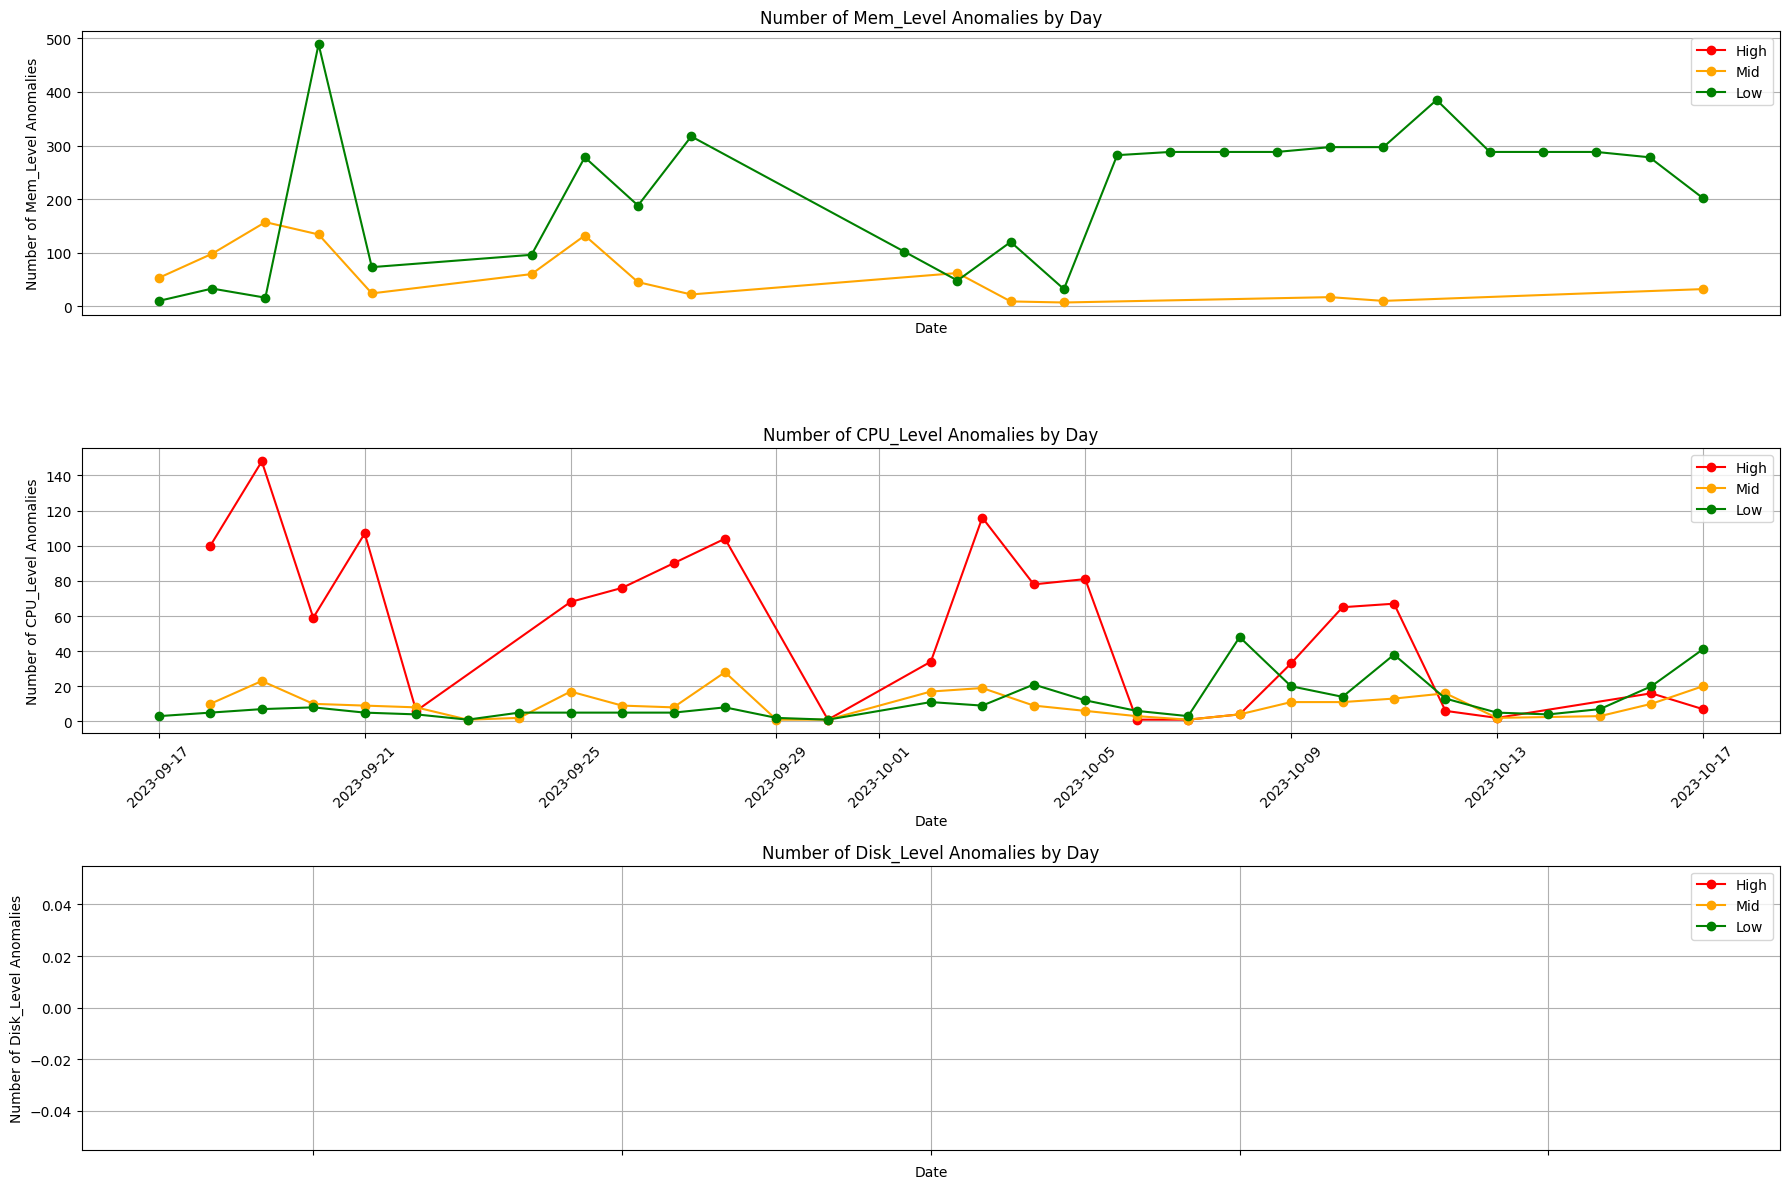

In [15]:
# Convert '_time' to datetime if it's not already in datetime format
all_anomalies.loc[:, '_time'] = pd.to_datetime(all_anomalies['_time'])

# Filter anomalies to include "High", "Mid", and "Low" anomalies for each metric
high_mem_anomalies = all_anomalies[all_anomalies['Mem_Level'] == 'High']
mid_mem_anomalies = all_anomalies[all_anomalies['Mem_Level'] == 'Mid']
low_mem_anomalies = all_anomalies[all_anomalies['Mem_Level'] == 'Low']
high_cpu_anomalies = all_anomalies[all_anomalies['CPU_Level'] == 'High']
mid_cpu_anomalies = all_anomalies[all_anomalies['CPU_Level'] == 'Mid']
low_cpu_anomalies = all_anomalies[all_anomalies['CPU_Level'] == 'Low']
high_disk_anomalies = all_anomalies[all_anomalies['Disk_Level'] == 'High']
mid_disk_anomalies = all_anomalies[all_anomalies['Disk_Level'] == 'Mid']
low_disk_anomalies = all_anomalies[all_anomalies['Disk_Level'] == 'Low']

# Aggregate "High", "Mid", and "Low" anomalies by day for each metric
high_mem_anomalies_by_day = high_mem_anomalies.groupby(high_mem_anomalies['_time'].dt.date).size()
mid_mem_anomalies_by_day = mid_mem_anomalies.groupby(mid_mem_anomalies['_time'].dt.date).size()
low_mem_anomalies_by_day = low_mem_anomalies.groupby(low_mem_anomalies['_time'].dt.date).size()
high_cpu_anomalies_by_day = high_cpu_anomalies.groupby(high_cpu_anomalies['_time'].dt.date).size()
mid_cpu_anomalies_by_day = mid_cpu_anomalies.groupby(mid_cpu_anomalies['_time'].dt.date).size()
low_cpu_anomalies_by_day = low_cpu_anomalies.groupby(low_cpu_anomalies['_time'].dt.date).size()
high_disk_anomalies_by_day = high_disk_anomalies.groupby(high_disk_anomalies['_time'].dt.date).size()
mid_disk_anomalies_by_day = mid_disk_anomalies.groupby(mid_disk_anomalies['_time'].dt.date).size()
low_disk_anomalies_by_day = low_disk_anomalies.groupby(low_disk_anomalies['_time'].dt.date).size()

# Plotting
plt.figure(figsize=(18, 12))

# Mem_Level Anomalies
plt.subplot(3, 1, 1)
high_mem_anomalies_by_day.plot(kind='line', color='red', marker='o', linestyle='-', label='High')
mid_mem_anomalies_by_day.plot(kind='line', color='orange', marker='o', linestyle='-', label='Mid')
low_mem_anomalies_by_day.plot(kind='line', color='green', marker='o', linestyle='-', label='Low')
plt.title('Number of Mem_Level Anomalies by Day')
plt.xlabel('Date')
plt.ylabel('Number of Mem_Level Anomalies')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# CPU_Level Anomalies
plt.subplot(3, 1, 2)
high_cpu_anomalies_by_day.plot(kind='line', color='red', marker='o', linestyle='-', label='High')
mid_cpu_anomalies_by_day.plot(kind='line', color='orange', marker='o', linestyle='-', label='Mid')
low_cpu_anomalies_by_day.plot(kind='line', color='green', marker='o', linestyle='-', label='Low')
plt.title('Number of CPU_Level Anomalies by Day')
plt.xlabel('Date')
plt.ylabel('Number of CPU_Level Anomalies')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

# Disk_Level Anomalies
plt.subplot(3, 1, 3)
high_disk_anomalies_by_day.plot(kind='line', color='red', marker='o', linestyle='-', label='High')
mid_disk_anomalies_by_day.plot(kind='line', color='orange', marker='o', linestyle='-', label='Mid')
low_disk_anomalies_by_day.plot(kind='line', color='green', marker='o', linestyle='-', label='Low')
plt.title('Number of Disk_Level Anomalies by Day')
plt.xlabel('Date')
plt.ylabel('Number of Disk_Level Anomalies')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# **Plot anomalies average per hour**

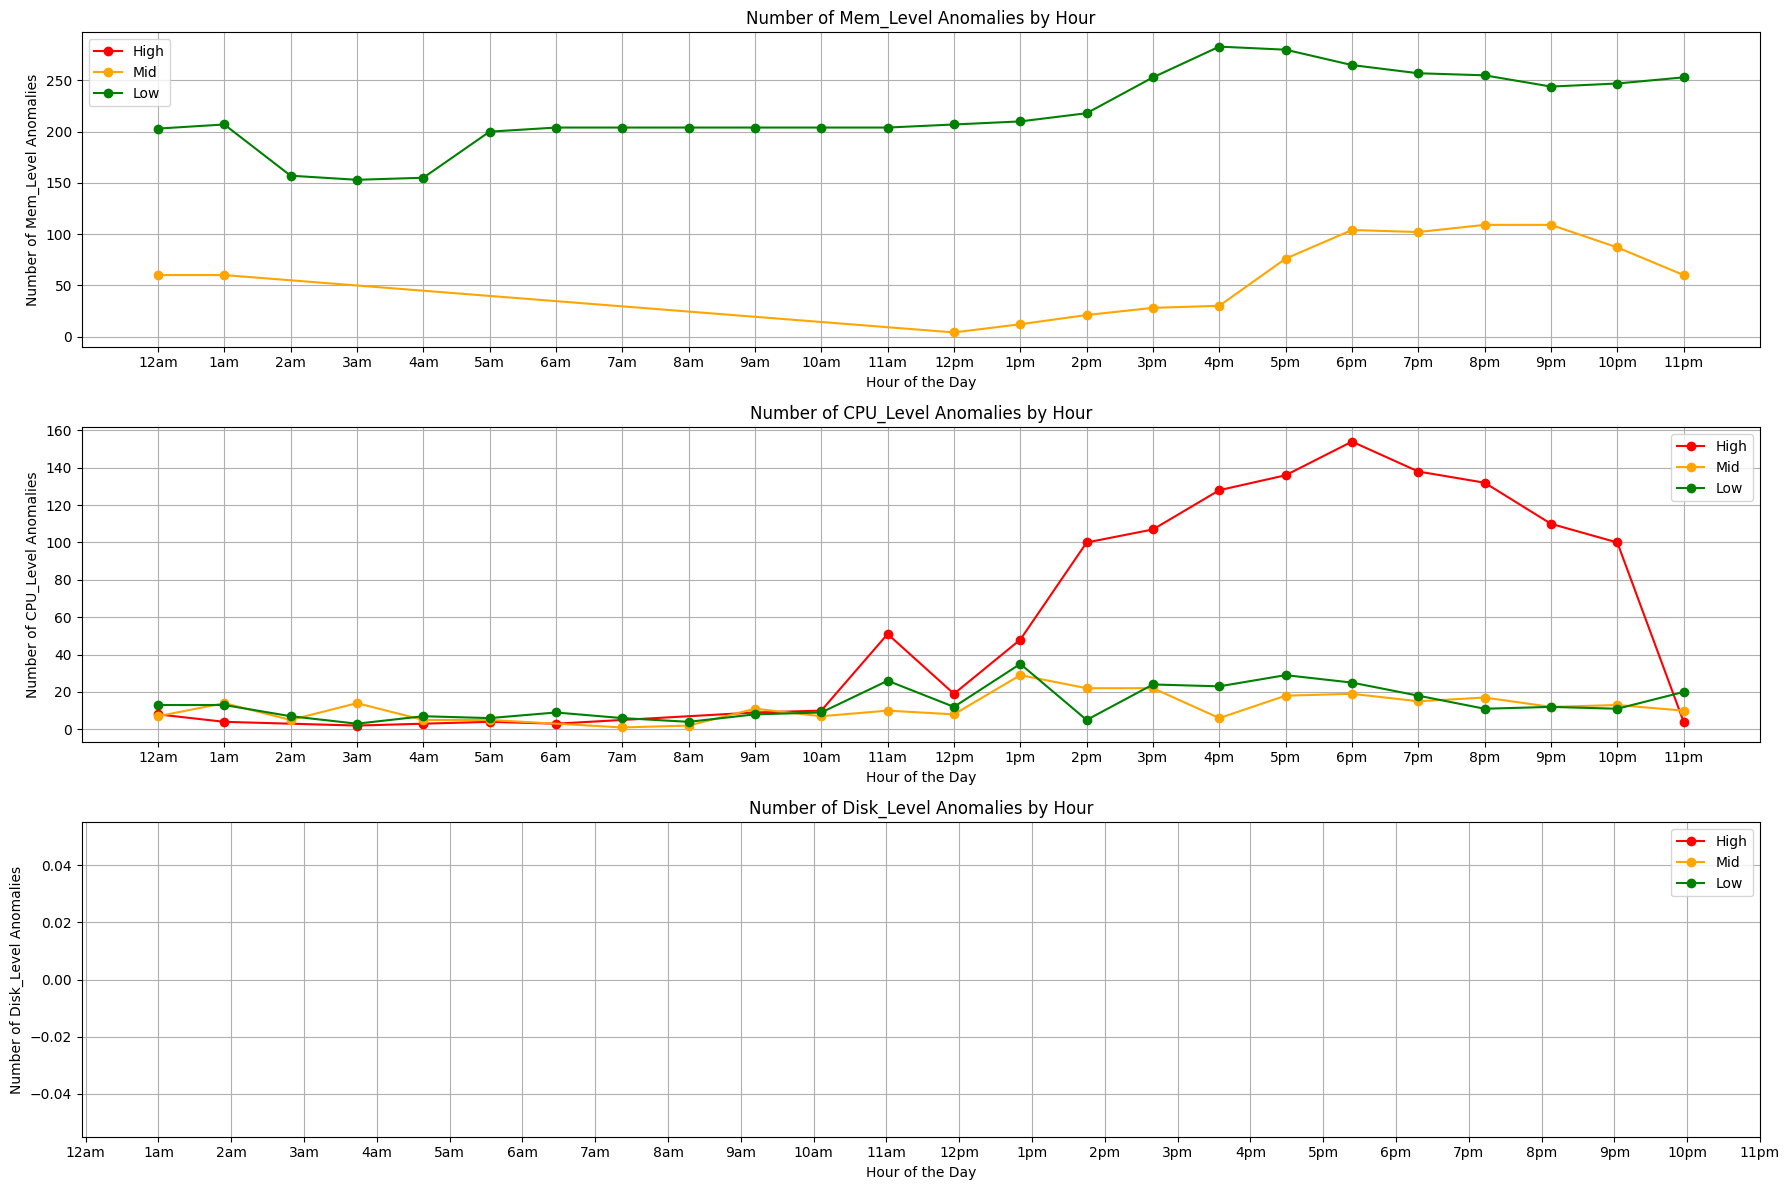

In [18]:
# Convert '_time' to datetime if it's not already in datetime format
all_anomalies.loc[:, '_time'] = pd.to_datetime(all_anomalies['_time'])

# Extract hour component from the timestamp
all_anomalies.loc[:, 'hour'] = all_anomalies['_time'].dt.hour

# Filter anomalies to include "High", "Mid", and "Low" anomalies for each metric
high_mem_anomalies = all_anomalies[all_anomalies['Mem_Level'] == 'High']
mid_mem_anomalies = all_anomalies[all_anomalies['Mem_Level'] == 'Mid']
low_mem_anomalies = all_anomalies[all_anomalies['Mem_Level'] == 'Low']
high_cpu_anomalies = all_anomalies[all_anomalies['CPU_Level'] == 'High']
mid_cpu_anomalies = all_anomalies[all_anomalies['CPU_Level'] == 'Mid']
low_cpu_anomalies = all_anomalies[all_anomalies['CPU_Level'] == 'Low']
high_disk_anomalies = all_anomalies[all_anomalies['Disk_Level'] == 'High']
mid_disk_anomalies = all_anomalies[all_anomalies['Disk_Level'] == 'Mid']
low_disk_anomalies = all_anomalies[all_anomalies['Disk_Level'] == 'Low']

# Aggregate "High", "Mid", and "Low" anomalies by hour for each metric
high_mem_anomalies_by_hour = high_mem_anomalies.groupby('hour').size()
mid_mem_anomalies_by_hour = mid_mem_anomalies.groupby('hour').size()
low_mem_anomalies_by_hour = low_mem_anomalies.groupby('hour').size()
high_cpu_anomalies_by_hour = high_cpu_anomalies.groupby('hour').size()
mid_cpu_anomalies_by_hour = mid_cpu_anomalies.groupby('hour').size()
low_cpu_anomalies_by_hour = low_cpu_anomalies.groupby('hour').size()
high_disk_anomalies_by_hour = high_disk_anomalies.groupby('hour').size()
mid_disk_anomalies_by_hour = mid_disk_anomalies.groupby('hour').size()
low_disk_anomalies_by_hour = low_disk_anomalies.groupby('hour').size()

# Plotting
plt.figure(figsize=(18, 12))

# Mem_Level Anomalies
plt.subplot(3, 1, 1)
high_mem_anomalies_by_hour.plot(kind='line', color='red', marker='o', linestyle='-', label='High')
mid_mem_anomalies_by_hour.plot(kind='line', color='orange', marker='o', linestyle='-', label='Mid')
low_mem_anomalies_by_hour.plot(kind='line', color='green', marker='o', linestyle='-', label='Low')
plt.title('Number of Mem_Level Anomalies by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Mem_Level Anomalies')
plt.xticks(range(0, 24), ['{}{}'.format(x % 12 or 12, 'am' if x < 12 else 'pm') for x in range(0, 24)])
plt.legend()
plt.grid(True)

# CPU_Level Anomalies
plt.subplot(3, 1, 2)
high_cpu_anomalies_by_hour.plot(kind='line', color='red', marker='o', linestyle='-', label='High')
mid_cpu_anomalies_by_hour.plot(kind='line', color='orange', marker='o', linestyle='-', label='Mid')
low_cpu_anomalies_by_hour.plot(kind='line', color='green', marker='o', linestyle='-', label='Low')
plt.title('Number of CPU_Level Anomalies by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of CPU_Level Anomalies')
plt.xticks(range(0, 24), ['{}{}'.format(x % 12 or 12, 'am' if x < 12 else 'pm') for x in range(0, 24)])
plt.legend()
plt.grid(True)

# Disk_Level Anomalies
plt.subplot(3, 1, 3)
high_disk_anomalies_by_hour.plot(kind='line', color='red', marker='o', linestyle='-', label='High')
mid_disk_anomalies_by_hour.plot(kind='line', color='orange', marker='o', linestyle='-', label='Mid')
low_disk_anomalies_by_hour.plot(kind='line', color='green', marker='o', linestyle='-', label='Low')
plt.title('Number of Disk_Level Anomalies by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Disk_Level Anomalies')
plt.xticks(range(0, 24), ['{}{}'.format(x % 12 or 12, 'am' if x < 12 else 'pm') for x in range(0, 24)])
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()